## Setup

In [1]:
#RUNNING ON ENVIRONMENT 'UNEXT'
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

from IPython.display import display
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm.auto import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Print Debugging on!

UNET V3
Last run on Tue Aug 23 17:25:11 2022
TorchIO version: 0.18.76


In [2]:
import os
dataset_dir = Path(os.getcwd() + "/ALL_DATA/gzorg/")
images_dir = dataset_dir / 'images'
labels_dir = dataset_dir / 'labels'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
print(len(label_paths))
print(len(image_paths))

assert len(image_paths) == len(label_paths)


import time
modded_subjects = []

for (image_path, label_path) in tqdm((zip(image_paths, label_paths))):
    subject = tio.Subject(
        sample=tio.ScalarImage(image_path),
        label =  tio.LabelMap(label_path)
    )
    # print(subject['label1'].tensor[:,:,:,0].shape)

    modded_subjects.append(subject)
    # time.sleep(0.5)

modded_subjects = modded_subjects

dataset = tio.SubjectsDataset(modded_subjects)

140
140


140it [00:00, 18045.56it/s]


In [3]:
len(dataset)

140

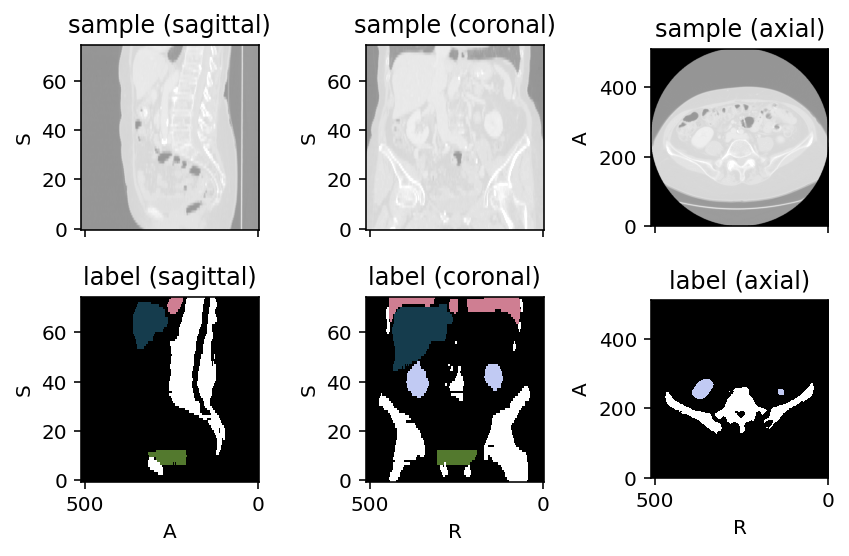

In [4]:
dataset[0].plot()

In [5]:
mul = 5
shapey = (48, mul*60, mul*48)
RESAMPLE_SPACE = 1 #RETAINS BASE RESOLUTION
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(RESAMPLE_SPACE),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.CropOrPad(shapey), #should this be after the flip?
    tio.RescaleIntensity((0,1)),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(RESAMPLE_SPACE),
    tio.CropOrPad(shapey),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])


dataset = tio.SubjectsDataset(modded_subjects) #can multiply size because of augmentation

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
print(num_split_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(modded_subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

training_set_raw = [] 
val_set_raw = []

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

(126, 14)
Training set: 126 subjects
Validation set: 14 subjects


### Lightning Converted Functions

In [6]:
import pytorch_lightning as pl
import os
import time
DATA_PATH = Path(os.getcwd() + "/DATA/")

In [7]:
#non class functions

import cv2
import numpy as np
  
import torchvision.transforms.functional as Ft

def prepare_batch(batch):
    inputs = batch['sample'][tio.DATA]
    targets = batch['label'][tio.DATA]
    return inputs, targets
def get_dice_score(output, target, epsilon=1e-9):
    # print(f"Output: {type(output)}, {output.shape}")
    # print(f"Target: {type(target)}, {output.shape}")
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    loss = 1 - get_dice_score(output, target)
    if type(loss) is None:
        return -1
    # print(f"LOSS TYPE: {type(loss)}")
    return loss



def tensor_to_video(inputs, name="TEST"):
  slices = []
  print()
  for i in range(inputs.size()[2]):
      slice = inputs[0, :,i,:,:];img = Ft.to_pil_image(slice, mode='L')
      # print(slice.size())
      slices.append(img)
  fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
  video = cv2.VideoWriter(f'{name}.mp4', fourcc, inputs.size()[2], (inputs.size()[4]  , inputs.size()[3]))

  for j in slices:
    j = np.array(j)
    shape = np.shape(j)
    opencvImage = cv2.cvtColor(j, cv2.COLOR_GRAY2BGR)
    video.write(opencvImage)

  cv2.destroyAllWindows()
  video.release()


In [8]:
RESAMPLE = 1 #4
class CATDataModule(pl.LightningDataModule):
    def __init__(self, train_batch_size, val_batch_size):
        super().__init__()
        image_mul = 4
        self.image_shape = (48, image_mul*60, image_mul*48)
        self.training_subjects = []
        self.validation_subjects = []
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.dataset = []
        self.num_workers = 8
        self.training_split_ratio = 0.9

    def prepare_data(self):
        dataset_dir = Path(os.getcwd() + "/ALL_DATA/gzorg/")
        images_dir = dataset_dir / 'images'
        labels_dir = dataset_dir / 'labels'
        image_paths = sorted(images_dir.glob('*.nii.gz'))
        label_paths = sorted(labels_dir.glob('*.nii.gz'))

        assert len(image_paths) == len(label_paths)
        self.dataset = []
        for (image_path, label_path) in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
            subject = tio.Subject(
                sample=tio.ScalarImage(image_path),
                label =  tio.LabelMap(label_path))
            self.dataset.append(subject)
            # time.sleep(0.1)
        # print(len(self.dataset))

    def setup(self, stage):

        num_training_subjects = int(self.training_split_ratio * len(self.dataset))
        num_validation_subjects = len(self.dataset) - num_training_subjects
        num_split_subjects = [num_training_subjects, num_validation_subjects]
        #WHY IS THIS NUMBER WRONG?
        self.training_subjects, self.validation_subjects = torch.utils.data.random_split(self.dataset, num_split_subjects)
    
    def train_dataloader(self):
        training_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(RESAMPLE),
                    tio.CropOrPad(self.image_shape),
                    tio.RandomMotion(p=0.2),
                    tio.RandomBiasField(p=0.3),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.RescaleIntensity([0,1]),
                    tio.RandomNoise(p=0.5),
                    tio.RandomFlip(),
                    tio.OneOf({
                        tio.RandomAffine(): 0.8,
                        tio.RandomElasticDeformation(): 0.2,
                    }),
                    tio.OneHot()])

        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(RESAMPLE),
                    tio.CropOrPad(self.image_shape),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                ])
        training_set = tio.SubjectsDataset(
                            training_subjects, transform=training_transform)

        training_loader = torch.utils.data.DataLoader(
                            training_set,
                            batch_size=self.train_batch_size,
                            shuffle=True,
                            num_workers=self.num_workers)
        return training_loader

    def val_dataloader(self):
        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(4),
                    tio.CropOrPad(shapey),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                ])
        validation_set = tio.SubjectsDataset(
                        validation_subjects, transform=validation_transform)
      
        validation_loader = torch.utils.data.DataLoader(
                        validation_set,
                        batch_size=self.val_batch_size,
                        shuffle=False,
                        num_workers=self.num_workers)
        return validation_loader

In [10]:
import wandb
# wandb.init(project="3dUnet")
wandb.config = {
    #Model Parameters
  "num_encoding_blocks":3,
  "out_channels_first_layer":8,
  "activation": "PReLU",
    #Training Parameters
  "learning_rate": 0.001,
  "epochs": 10,
  "train_batch_size": 4,
  "val_batch_size":4
}


In [11]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=wandb.config['num_encoding_blocks'],
        out_channels_first_layer=wandb.config['out_channels_first_layer'],
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation=wandb.config['activation'])
    def forward(self, x):
        return self.model(x)
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=wandb.config['learning_rate'])
        return optimizer
    def training_step(self, train_batch, batch_index):
        inputs = train_batch['sample'][tio.DATA]
        targets = train_batch['label'][tio.DATA]
        with torch.enable_grad():
            logits = self.model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
        self.log('train_loss', batch_loss.item())
        return {'loss': batch_loss}
   
    def validation_step(self, val_batch, batch_index):
        inputs, targets = prepare_batch(val_batch)
        with torch.no_grad():
            logits = self.model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
        self.log('val_loss', batch_loss.item())
        return {'loss': batch_loss}
    
    def predict_step(self, batch, batch_idx, datloader_idx=0):
        prediction = self(batch)
        return prediction
    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    # def optimizer_step(self,epoch=None, batch_idx=None, optimizer=None, optimizer_idx=None, optimizer_closure=None, on_tpu=None, using_native_amp=None, using_lbfgs=None):
    #     optimizer.step()
    #     optimizer.closure()

        



In [16]:
datamodule = CATDataModule(4,4)
datamodule.prepare_data()
datamodule.setup(0)
# # mod = module.val_dataloader()
model = Segmenter()
trainer = pl.Trainer(accelerator='gpu', fast_dev_run=False)
trainer.tune(model, datamodule=datamodule)
trainer.fit(model, datamodule=datamodule)

100%|██████████| 140/140 [00:00<00:00, 17669.26it/s]

<function ppl at 0x7f38cf89f9d0>



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 140/140 [00:00<00:00, 18200.49it/s]
Missing logger folder: /home/orolo/Documents/GH_REPOS/MRIProject/lightning_logs


<function ppl at 0x7f38cf89f9d0>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 246 K 
-------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.985     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]In Shape: torch.Size([4, 64, 12, 75, 60])

Post Upsample Shape: torch.Size([4, 64, 24, 150, 120])

 skip Shape: torch.Size([4, 32, 24, 150, 120])

In Shape: torch.Size([4, 32, 24, 150, 120])

Post Upsample Shape: torch.Size([4, 32, 48, 300, 240])

 skip Shape: torch.Size([4, 16, 48, 300, 240])



/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/unet/decoding.py:154: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:05<00:05,  5.11s/it]

/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:86: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 157, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 157, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 157, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 157, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 138, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: result type Float can't be cast to the desired output type Int


In [ ]:
#multiply by 255 to solve pictute issue?

In [18]:
d = datamodule.train_dataloader()
d = iter(d)
sub =  next(d)
inputs = sub['sample'][tio.DATA]
# print(inputs)
# tensor_to_video(inputs)

/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:263: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0], so folding may occur. Choose fewer control points or a smaller maximum displacement
  warnings.warn(message, RuntimeWarning)
/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:263: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0], so folding may occur. Choose fewer control points or a smaller maximum displacement
  warnings.warn(message, RuntimeWarning)


RuntimeError: DataLoader worker (pid(s) 12467) exited unexpectedly

/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:263: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0], so folding may occur. Choose fewer control points or a smaller maximum displacement
  warnings.warn(message, RuntimeWarning)


In [ ]:
n = inputs.numpy()
n = n[:,:,0,0,0]
print(np.shape(n))
print(n[:,0])

In [ ]:
inputs.shape

### Unconverted Functions

In [ ]:
def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=wandb.config['num_encoding_blocks'],
        out_channels_first_layer=wandb.config['out_channels_first_layer'],
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation=wandb.config['activation'],
    ).to(device)
    # print(model.parameters)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config['learning_rate'])
    return model, optimizer

In [ ]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

# def prepare_batch(batch, device):
#     if device != None:
#         inputs = batch['sample'][tio.DATA].to(device)
#         targets = batch['label'][tio.DATA].to(device)
#     else:
#         inputs = batch['sample'][tio.DATA]
#         targets = batch['label'][tio.DATA]

#     print(f"DTYPE: {type(inputs)}")
#     return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=wandb.config['num_encoding_blocks'],
        out_channels_first_layer=wandb.config['out_channels_first_layer'],
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation=wandb.config['activation'],
    ).to(device)
    # print(model.parameters)
    optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config['learning_rate'])
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            print(f"dtype: {inputs[0][0][0]}")
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss)
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean()}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
   

    # val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):


        print('Starting epoch', epoch_idx)
        train_loss = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        train_losses.append(train_loss)
        val_loss = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        val_losses.append(val_loss)

        wandb.log({"val_loss": val_loss})
        wandb.log({"train_loss": train_loss})

        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

In [ ]:
module.training_subjects[1].plot()

In [ ]:
tens = training_subjects[0].sample.data


In [ ]:
import random
ind = random.randint(0,tens.size()[1])
slice = tens[:, ind,:,:]
import torchvision.transforms.functional as Ft
img = Ft.to_pil_image(slice)

display(img)


In [ ]:
edited_tens = 

In [ ]:
#plot 1 tensor, verify color space redux works

In [ ]:
dic = {}
dic['sample'] = it['sample'].data

In [ ]:
import wandb
wandb.init(project="3dUnet")
wandb.config = {
    #Model Parameters
  "num_encoding_blocks":3,
  "out_channels_first_layer":8,
  "activation": "PReLU",
    #Training Parameters
  "learning_rate": 0.001,
  "epochs": 10,
  "train_batch_size": 4,
  "val_batch_size":4
  
}

In [ ]:
if (torch.cuda.is_available()):
    print("Cuda is available")
model, optimizer = get_model_and_optimizer(device)
# wandb.watch(model)
weights_path = 'whole_image_state_dict.pth'
training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=wandb.config['train_batch_size'],
    shuffle=True,
    num_workers=1,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=wandb.config['val_batch_size'],
    num_workers=1,
)



In [ ]:
weights_stem = 'whole_images'
train_losses, val_losses = train(wandb.config['epochs'], training_loader, validation_loader, model, optimizer, weights_stem)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
torch.save(checkpoint, weights_path)


#### Test

In [ ]:
def staty(image):
    print(f"This image is {image.size[0]} by {image.size[1]}")
    arr = np.array(image)
    print(f"Mean pixel value is {np.mean(arr)}")
    print(f"Median pixel value is {np.median(arr)}")
    print(f"Minimum is {np.min(arr)}, Max is {np.max(arr)}")

In [ ]:
import torchvision.transforms as tv
convert = tv.Compose([tv.ToPILImage()])
slices = []
for i in range(6):
    slices.append(probabilities[:,i,24,:,:])

# im = convert(slices[1])
# imshow(im)
# stats(im)
affine = batch['sample'][tio.AFFINE][0].numpy()
ind = 24

pl1 = inputs.cpu()
pl2 = targets.cpu()
probs = probabilities.cpu()
subject = tio.Subject(
    scan=tio.ScalarImage(tensor=pl[:,:,ind,:,:]),
    label1=tio.LabelMap(tensor=pl2[:,:,ind,:,:],),
    predicted=tio.ScalarImage(tensor=probs[:,:,ind,:,:]),
)
subject.plot(figsize=(9, 8))#, cmap_dict={'predicted': 'RdBu_r'})

In [ ]:
# batch = next(iter(validation_loader))
batch = next(iter(training_loader))

model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['sample'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['sample'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['label'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})